In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler,Normalizer
import lightgbm as lgb
from scipy.special import boxcox1p
from sklearn.linear_model import Ridge
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [28]:
X = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")
X.drop(['GarageYrBlt'], axis=1, inplace=True)
X.drop(['Utilities'], axis=1, inplace=True)
X_test.drop(['GarageYrBlt'], axis=1, inplace=True)
X_test.drop(['Utilities'], axis=1, inplace=True)


 mu = 180921.20 and sigma = 79415.29



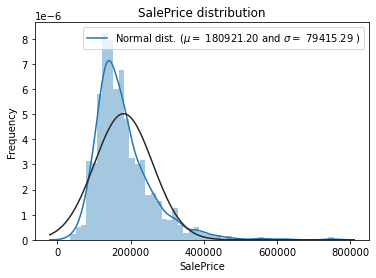

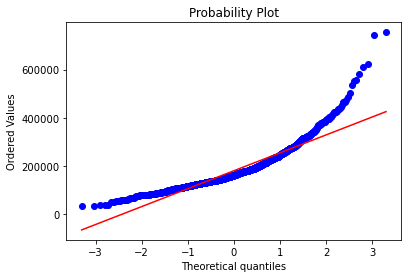


 mu = 12.02 and sigma = 0.40



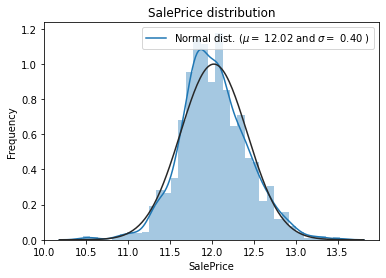

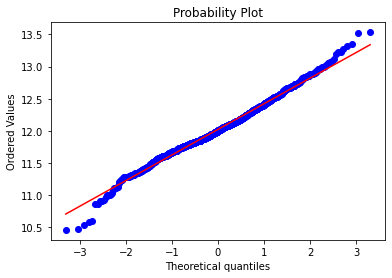

In [29]:
class cleaner(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):


        


        X.Electrical = X.Electrical.fillna('SBrkr')
        X.BsmtFinSF1 = X.BsmtFinSF1.fillna(0)
        X.BsmtFinSF2 = X.BsmtFinSF2.fillna(0)
        X.GarageCars = X.GarageCars.fillna(0)
        X.GarageArea = X.GarageArea.fillna(0)
        X["PoolQC"] = X["PoolQC"].fillna("NA")
        X.BsmtQual[(X.BsmtFinSF1 == 0)] = X.BsmtQual[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtCond[(X.BsmtFinSF1 == 0)] = X.BsmtCond[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtCond = X.BsmtCond.fillna('TA')
        X.BsmtExposure[(X.BsmtFinSF1 == 0)] = X.BsmtExposure[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtFinType1[(X.BsmtFinSF1 == 0)] = X.BsmtFinType1[(X.BsmtFinSF1 == 0)].fillna('NA')
        X.BsmtFinType2[(X.BsmtFinSF2 == 0)] = X.BsmtFinType2[(X.BsmtFinSF2 == 0)].fillna('NA')
        X.BsmtFinType2 = X.BsmtFinType2.fillna('Unf')
        X["MiscFeature"] = X["MiscFeature"].fillna("NA")
        X["Alley"] = X["Alley"].fillna("NA")
        X["Fence"] = X["Fence"].fillna("NA")
        X["FireplaceQu"] = X["FireplaceQu"].fillna("NA")
        X['MSSubClass'] = X['MSSubClass'].fillna("NA")
        for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
            X[col] = X[col].fillna('NA')

        #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
        X["LotFrontage"] = X.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))

        X.MasVnrArea = X.MasVnrArea.fillna(0)
        X.MasVnrType = X.MasVnrType.fillna('None')
        X.KitchenQual = X.KitchenQual.fillna('TA')
        X.Functional = X.Functional.fillna('Typ')
        X.BsmtUnfSF = X.BsmtUnfSF.fillna(0)
        X.TotalBsmtSF = X.TotalBsmtSF.fillna(0)
        X.BsmtFullBath = X.BsmtFullBath.fillna(0)
        X.BsmtHalfBath = X.BsmtHalfBath.fillna(0)

        #feature engineering for the Neighborhood
        X.loc[(X.Neighborhood == 'NridgHt') | (X.Neighborhood == 'NoRidge'), ['GoodNBH']] = 1
        X.GoodNBH = X.GoodNBH.fillna(0)
        X = X.drop(['Neighborhood'], axis=1)

        #Drop Categoricals that cannot be one hotted, and also not ordinally encoded
        X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode()[0])
        X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode()[0])

        X['MSZoning'] = X['MSZoning'].fillna(X['MSZoning'].mode()[0])
        X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])

        #Convert data thats really categorical
        X['MSSubClass'] = X['MSSubClass'].apply(str) 
        X['OverallQual'] = X['OverallQual'].astype(str)  
        X['OverallCond'] = X['OverallCond'].astype(str)    
        X['YrSold'] = X['YrSold'].astype(str)
        X['MoSold'] = X['MoSold'].astype(str)
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']       
        
        return X


class unskew(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        skewed_features = ['MiscVal','PoolArea','LotArea','3SsnPorch','LowQualFinSF', 'KitchenAbvGr','BsmtFinSF2','BsmtHalfBath','ScreenPorch','EnclosedPorch','MasVnrArea','OpenPorchSF','WoodDeckSF' ,'LotFrontage','BsmtUnfSF','1stFlrSF' ,'GrLivArea','2ndFlrSF']
        lam = 0.15
        for feat in skewed_features:
            X[feat] = boxcox1p(X[feat], lam)
        
        return X
    
    
    
class df_Ord(BaseEstimator, TransformerMixin):
    def __init__(self,cols = [] ,cats = []):
        self.ord = None
        self.cols = cols
        self.cats = cats
      

    def fit(self, X, y=None):
        if self.cats == []:
            self.ord = OrdinalEncoder(categories="auto")
        else:
            self.ord = OrdinalEncoder(categories=[self.cats])
            
        for col in self.cols:

            self.ord.fit(X[[col]])        
        return self

    def transform(self, X):
        # X has to be a dataframe
        Xord = X.copy()
        for col in self.cols:
            Xord[col] = self.ord.transform(X[[col]])                
        Xorded = pd.DataFrame(Xord, index=X.index, columns=X.columns)
        return Xorded

class df_OH(BaseEstimator, TransformerMixin):
    def __init__(self,cols = []):
        self.OH = None
        self.cols = cols

    def fit(self, X, y=None):
        
        self.OH = OneHotEncoder(handle_unknown='ignore', sparse=False)


        self.OH.fit(X[self.cols])        
        return self

    def transform(self, X):

        XOHedcols = pd.DataFrame(self.OH.transform(X[self.cols]))  
        XOHedcols.index = X.index
        numX = X.drop(self.cols, axis=1)
        XOHed = pd.concat([numX,XOHedcols], axis=1)
        return XOHed    
    

#correcting right Skew of data

sns.distplot(X['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X['SalePrice'], plot=plt)
plt.show()


#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
X["SalePrice"] = np.log1p(X["SalePrice"])

#Check the new distribution 
sns.distplot(X['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X['SalePrice'], plot=plt)
plt.show()

#drop outlier
X = X.drop(X[(X['GrLivArea']>4000) & (X['SalePrice']<300000)].index)


X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)    
    

<AxesSubplot:>

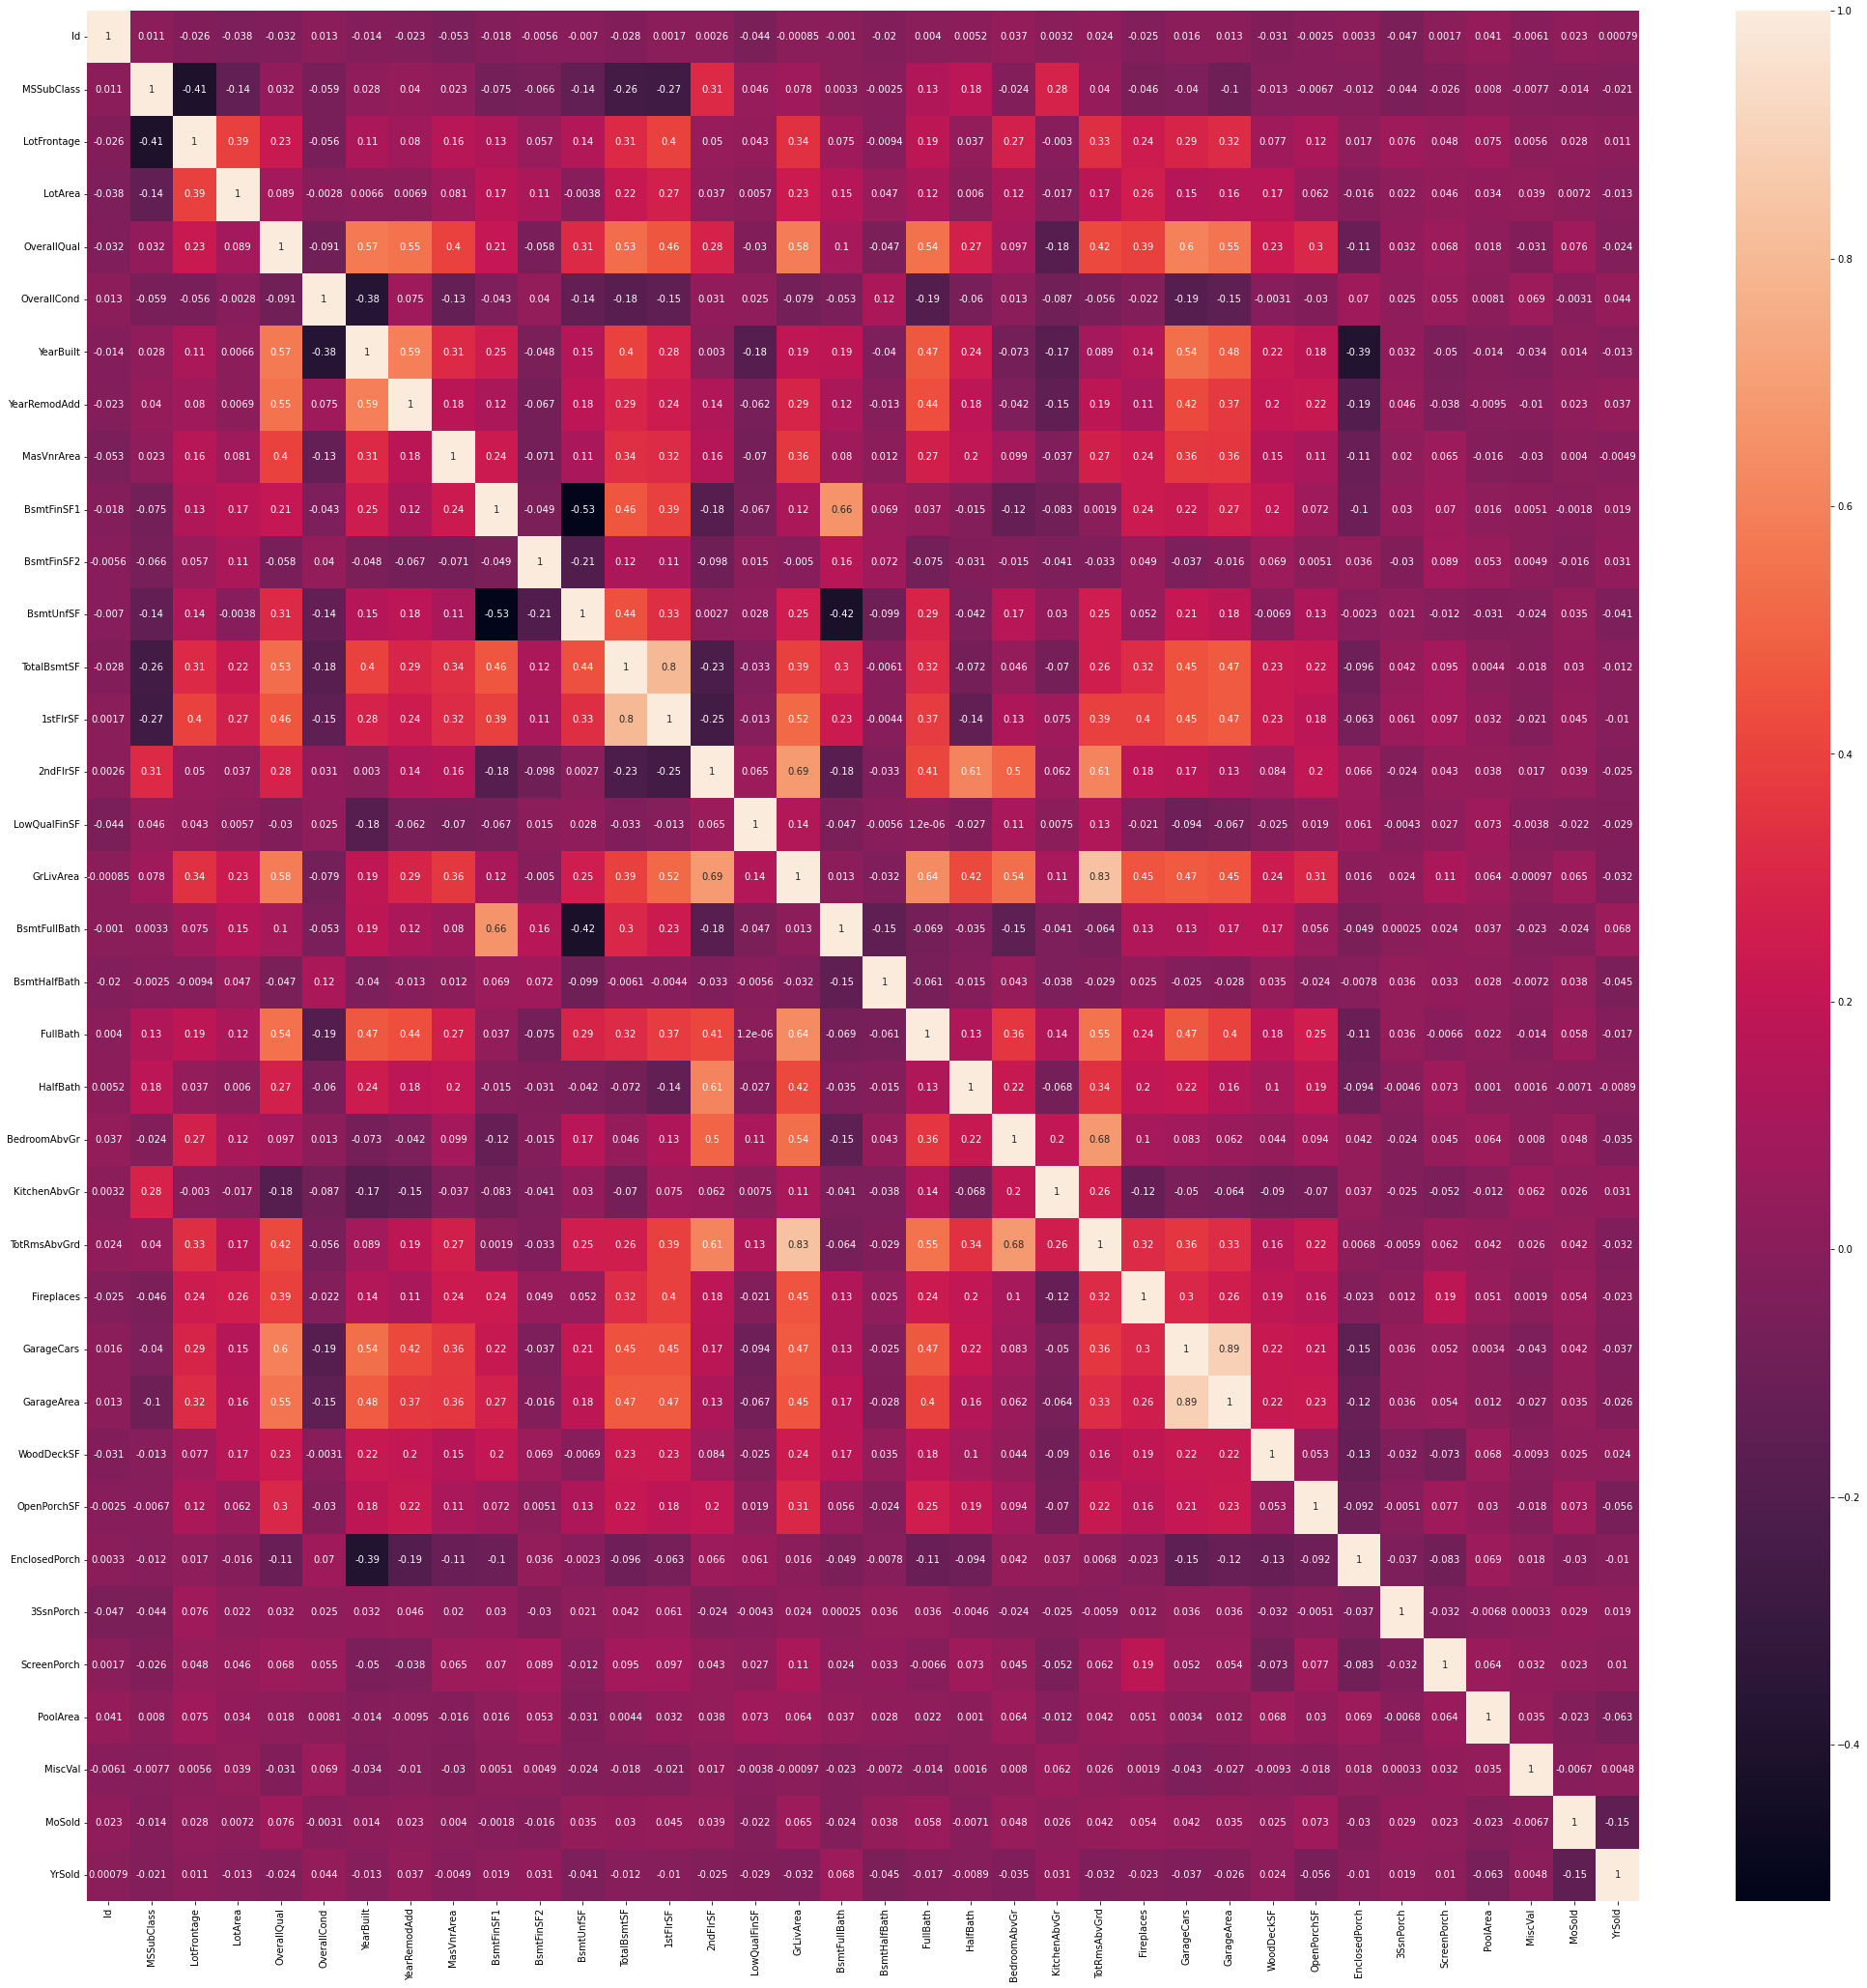

In [30]:
fig, ax = plt.subplots(figsize=(36, 36))
df_corr = X.corr()

sns.heatmap(df_corr,annot=True)

In [45]:
regressors = [
    RandomForestRegressor(n_estimators=800, random_state=0)
    ,XGBRegressor(colsample_bytree=0.7
                     , gamma=0.06
                     , min_child_weight=8
                     , subsample=0.6
                     , learning_rate=0.06
                     , max_depth=5
                     , num_leaves=20
                     , n_estimators=400)
    ,Lasso(alpha =0.0006,random_state=0,max_iter=1000)
    ,Ridge(alpha =17, random_state=0)
    ,ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
    ,lgb.LGBMRegressor(objective='regression',num_leaves=7,
                              learning_rate=0.02, n_estimators=800,
                              max_bin = 48, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 10)

    ]




for regressor in regressors:
    pipe = Pipeline([
                         ('clean', cleaner())
                         ,('ord',df_Ord(cols=['ExterQual','ExterCond','HeatingQC','KitchenQual'], cats=['Po','Fa','TA','Gd','Ex']))
                         ,('ord2',df_Ord(cols=['BsmtQual','BsmtCond','FireplaceQu','GarageQual','GarageCond'], cats=['NA','Po','Fa','TA','Gd','Ex']))
                         ,('ord3',df_Ord(cols=['PoolQC'], cats=['NA','Fa','TA','Gd','Ex']))
                         ,('ord4',df_Ord(cols=['MiscFeature'], cats=['NA','Othr','Shed','Gar2','Elev','TenC']))
                         ,('ord5',df_Ord(cols=['Fence'], cats=['NA','MnWw','GdWo','MnPrv','GdPrv']))
                         ,('ord6',df_Ord(cols=['Alley'], cats=['NA','Grvl','Pave']))
                         ,('ord7',df_Ord(cols=['BsmtExposure'], cats=['NA','No','Mn','Av','Gd']))
                         ,('ord8',df_Ord(cols=['BsmtFinType1','BsmtFinType2'], cats=['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'])) 
                         ,('ord9',df_Ord(cols=['CentralAir'], cats=['N','Y'])) 
                         ,('ord10',df_Ord(cols=['Functional'], cats=['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']))
                         ,('ord11',df_Ord(cols=['MSSubClass'], cats=['20','30','40','45','50','60','70','75','80','85','90','120','150','160','180','190']))
                         ,('ord12',df_Ord(cols=['YrSold']))
                         ,('ord13',df_Ord(cols=['MoSold']))
                         ,('ord14',df_Ord(cols=['OverallCond']))
                         ,('ord15',df_Ord(cols=['OverallQual']))
                         ,('ord16',df_Ord(cols=['GarageType']))
                         ,('ord17',df_Ord(cols=['GarageFinish']))
                         ,('ord18',df_Ord(cols=['Exterior1st']))
                         ,('ord19',df_Ord(cols=['Exterior2nd']))                          
                         ,('oh1',df_OH(cols=['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'PavedDrive', 'SaleType', 'SaleCondition']))
                         ,('unskew', unskew())
                         #,('scaler', RobustScaler())
                         #,('norm', Normalizer())
                         ,('model', regressor)
                         ])
    pipe.fit(X_train, y_train)   
    print(regressor)
    
    preds = pipe.predict(X_valid)
    print("model score: %.3f" % mean_absolute_error(np.expm1(y_valid), np.expm1(preds)))
    
    
    df = pd.DataFrame(columns=['Id','SalePrice'])
df['Id'] = X_valid.Id
df['SalePrice'] = np.expm1(preds)
df[['Id','SalePrice']].to_csv('submission1.csv', index=False)
    

RandomForestRegressor(n_estimators=800, random_state=0)
model score: 16076.740
[17:38:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.06, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.06, max_delta_step=0, max_depth=5,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=8, num_leaves=20, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, s